# BCI VI 2a(A03T)

In [3]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy.io
import mne_bids
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
import picard
import pathlib
from mne.decoding import CSP
from mne.viz import plot_evoked_topo
import os.path
import os.path as op
from os import path
import nibabel

### Импорт необработанных данных

*List of event types*

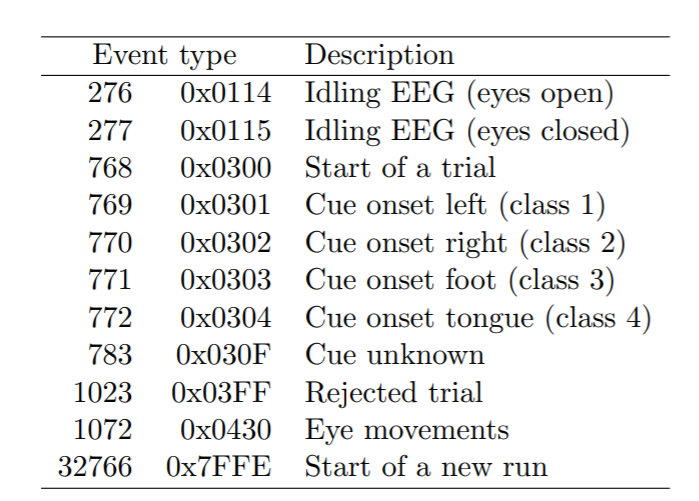

Extracting EDF parameters from D:\JupyterProjects\Data\BCI VI 2a\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
[]
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


D:\Python\lib\site-packages\mne\io\edf\edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
D:\Python\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Using matplotlib as 2D backend.


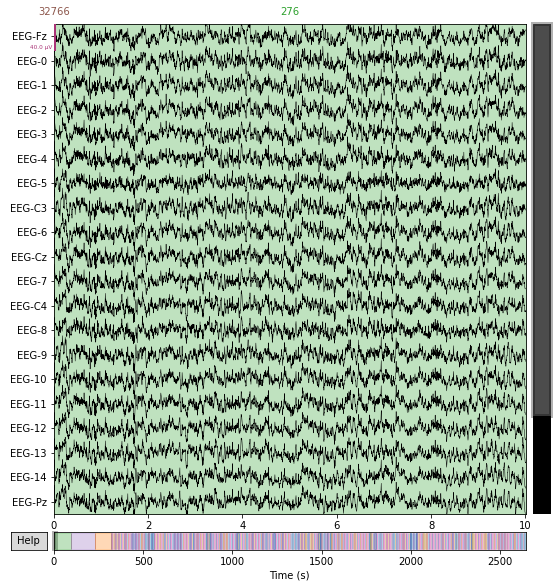

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [4]:
"""Importing raw data"""
raw = mne.io.read_raw_gdf('.\Data\BCI VI 2a\A03T.gdf', stim_channel="auto")
print(raw.info['bads'])
raw.load_data()

"""Viewing raw data"""
raw.plot()
##raw.plot_sensors(ch_type='eeg')
##raw.plot_sensors(ch_type='eeg', kind='3d')

"""Finding events/event ids"""
event = mne.events_from_annotations(raw)
events = event[0]
event_id = event[1]

### Фильтрация необработанных данных и построение спектральной плотности мощности

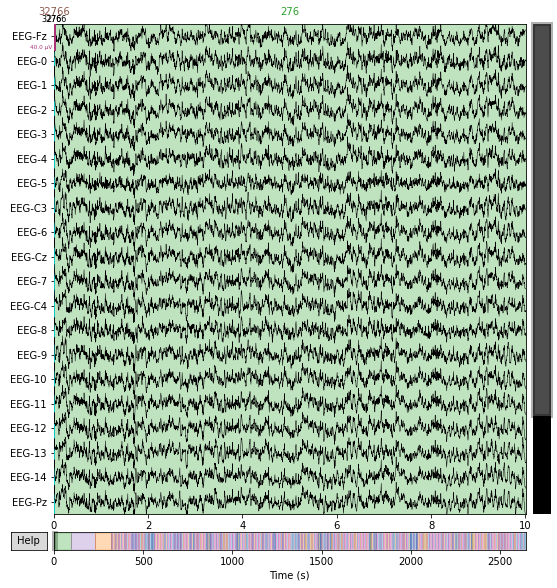

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8251 samples (33.004 sec)



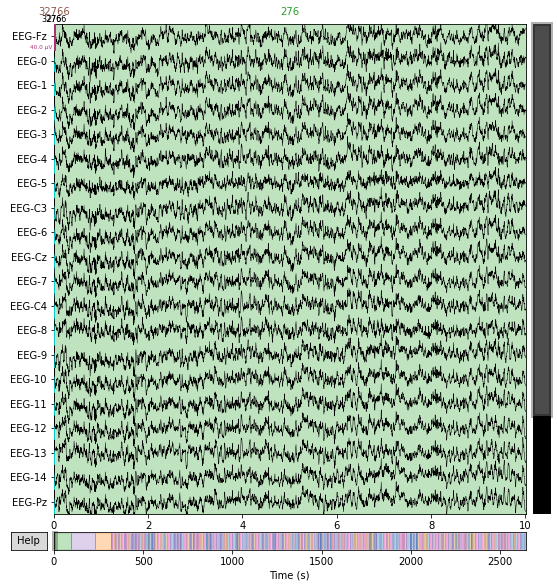

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)


C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/2628945870.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_eeg.plot_psd(ax=ax[0], show=False) #spatial_colors=True)
C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/2628945870.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_eeg_filtered.plot_psd(ax=ax[1], show=False) #spatial_colors=True)


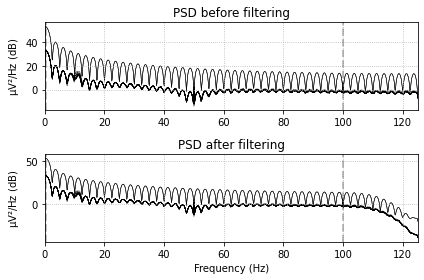

In [5]:
"""Applying filters and plotting PSDs"""
raw_eeg = raw.copy().pick_types(meg=False, eog=False, eeg=True)
raw_eeg.plot(events=events, event_id=event_id, title="Unfiltered EEG")

raw_eeg.load_data()
raw_eeg_filtered = raw_eeg.copy().filter(l_freq=0.1, h_freq=100)
raw_eeg_filtered.plot(events=events, event_id=event_id, title="Filtered EEG")

fig, ax = plt.subplots(2)
raw_eeg.plot_psd(ax=ax[0], show=False) #spatial_colors=True)
raw_eeg_filtered.plot_psd(ax=ax[1], show=False) #spatial_colors=True)
ax[0].set_title('PSD before filtering')
ax[1].set_title('PSD after filtering')
ax[1].set_xlabel('Frequency (Hz)')
fig.set_tight_layout(True)

### Эпохи и вызванная информация

*Timing scheme of the paradigm*

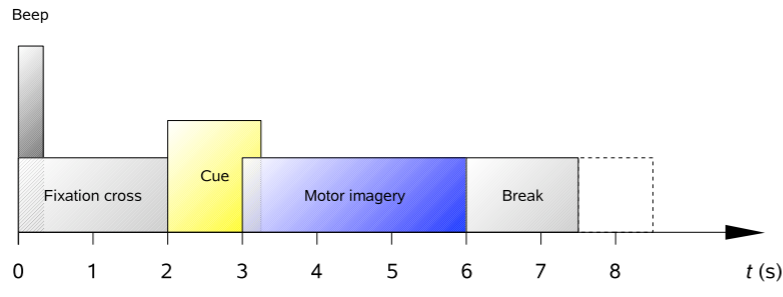

Not setting metadata
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
585 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 585 events and 626 original time points ...
0 bad epochs dropped

Epochs Info:
<Epochs |  585 events (all good), 2.5 - 5 sec, baseline 2.75 – 5 sec, ~69.9 MB, data loaded,
 '32766': 9
 '768': 288
 '769': 72
 '770': 72
 '771': 72
 '772': 72>


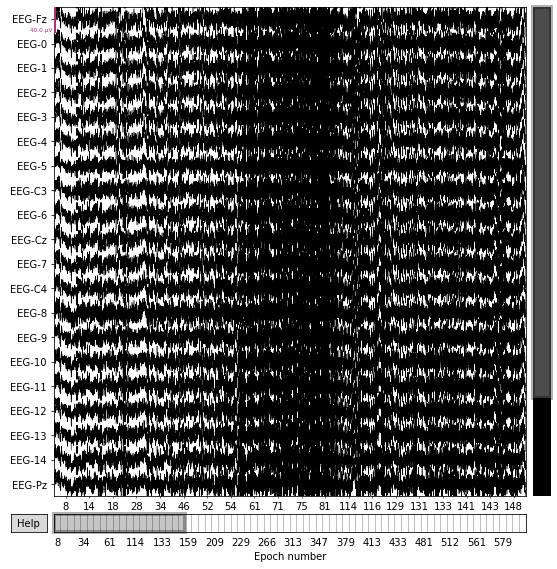

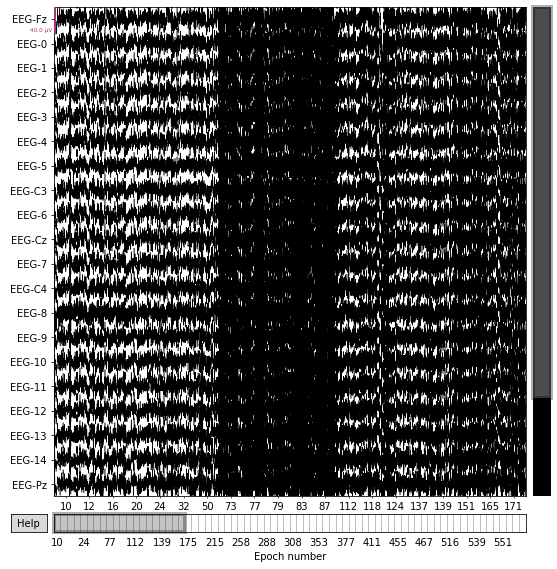

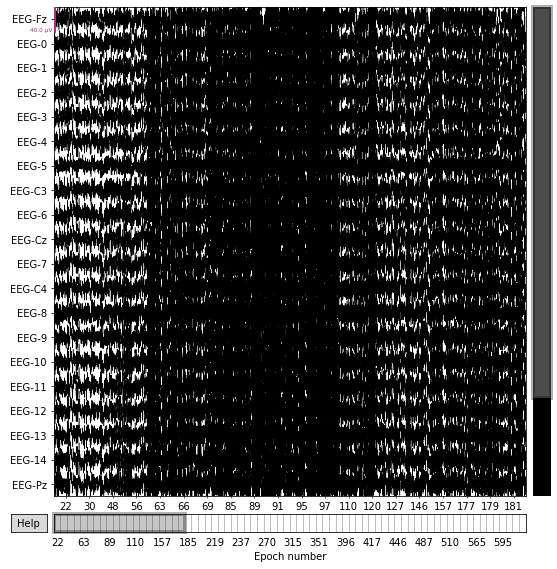

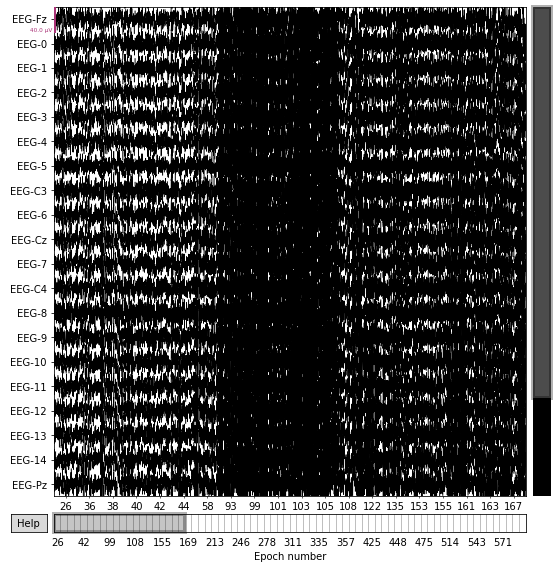

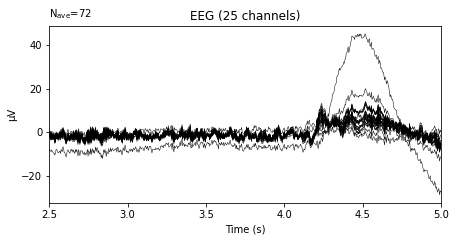

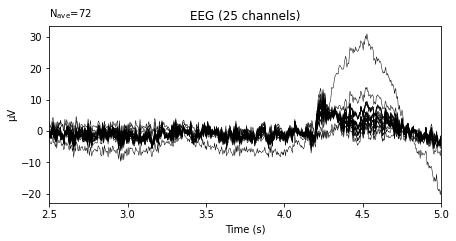

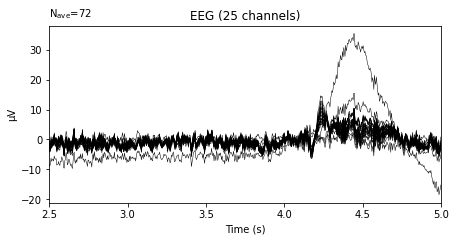

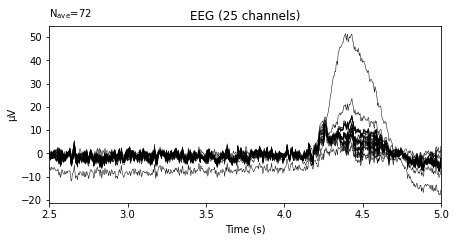

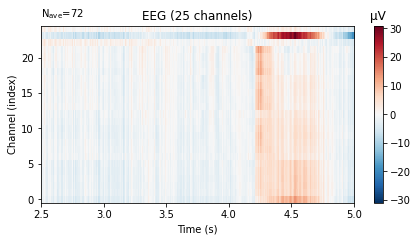

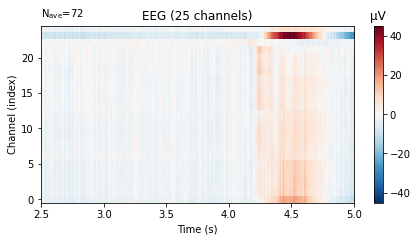

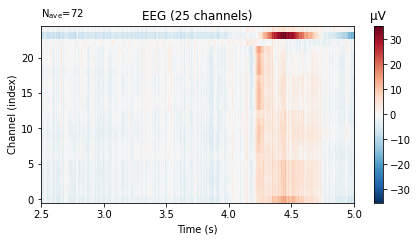

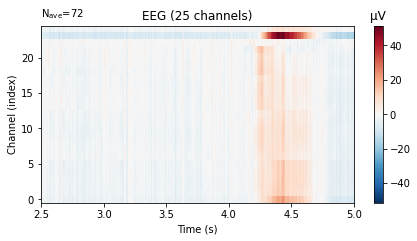

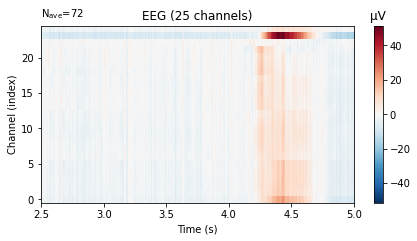

In [6]:
tmin = 2.5
tmax = 5
baseline = (2.75, 5)

epochs = mne.Epochs(raw_eeg_filtered,
                    events=events,
                    event_id=event_id,
                    event_repeated='drop',
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True)
print("\nEpochs Info:")
print(epochs)

##epochs.save(pathlib.Path('out_data') / 'epochs_epo.fif',
  ##          overwrite=True)

epochs['769'].plot()
epochs['770'].plot()
epochs['771'].plot()
epochs['772'].plot()

"""Evoked Data Information"""
noise_cov = mne.compute_covariance(epochs, tmax=8, method='shrunk', rank=None,
                                   verbose='error')
evoked_left = epochs['769'].average()
evoked_right = epochs['770'].average()
evoked_foot = epochs['771'].average()
evoked_toungh = epochs['772'].average()

evoked_left.plot()##spatial_colors=True)
evoked_right.plot()
evoked_foot.plot()
evoked_toungh.plot()
#evoked_foot.plot_topomap(ch_type='eeg')

evoked_right.plot_image(picks='eeg')
evoked_left.plot_image(picks='eeg')
evoked_foot.plot_image(picks='eeg')
evoked_toungh.plot_image(picks='eeg')

combining channels using "mean"
combining channels using "mean"


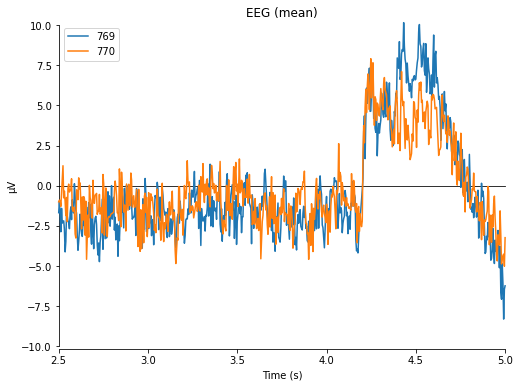

combining channels using "median"
combining channels using "median"


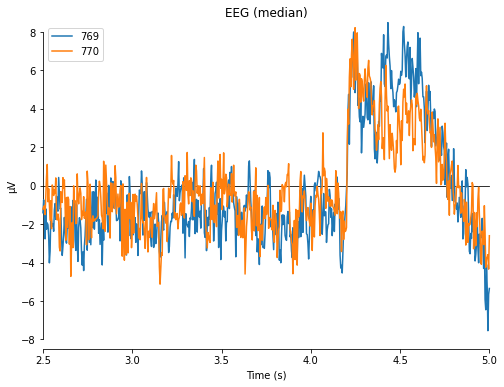

combining channels using "gfp"
combining channels using "gfp"


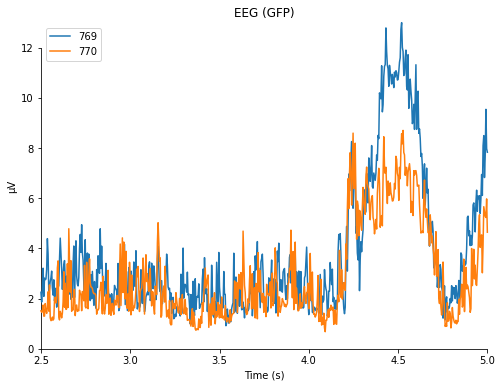

combining channels using "<function custom_func at 0x000002C94ADB2670>"
combining channels using "<function custom_func at 0x000002C94ADB2670>"


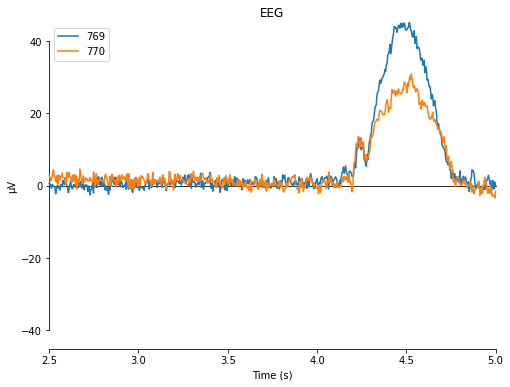

Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 25 dim * 34  max singular value)
    Estimated rank (eeg): 25
    EEG: rank 25 computed from 25 data channels with 0 projectors
Computing rank from covariance with rank={'eeg': 25}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 25 (0 small eigenvalues omitted)


C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/4046657221.py:6: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked_right.plot_white(noise_cov=noise_cov, time_unit='s')


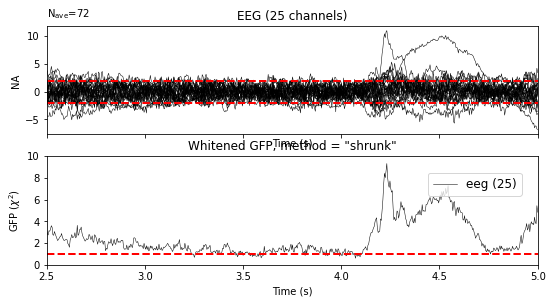

Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 25 dim * 34  max singular value)
    Estimated rank (eeg): 25
    EEG: rank 25 computed from 25 data channels with 0 projectors
Computing rank from covariance with rank={'eeg': 25}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 25 (0 small eigenvalues omitted)


C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/4046657221.py:7: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked_left.plot_white(noise_cov=noise_cov, time_unit='s')


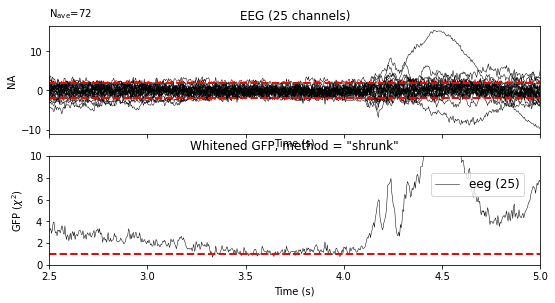

Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 25 dim * 34  max singular value)
    Estimated rank (eeg): 25
    EEG: rank 25 computed from 25 data channels with 0 projectors
Computing rank from covariance with rank={'eeg': 25}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 25 (0 small eigenvalues omitted)


C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/4046657221.py:8: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked_foot.plot_white(noise_cov=noise_cov, time_unit='s')


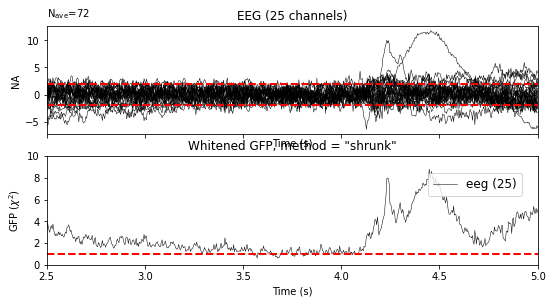

Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 25 dim * 34  max singular value)
    Estimated rank (eeg): 25
    EEG: rank 25 computed from 25 data channels with 0 projectors
Computing rank from covariance with rank={'eeg': 25}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 25 (0 small eigenvalues omitted)


C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/4046657221.py:9: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked_toungh.plot_white(noise_cov=noise_cov, time_unit='s')


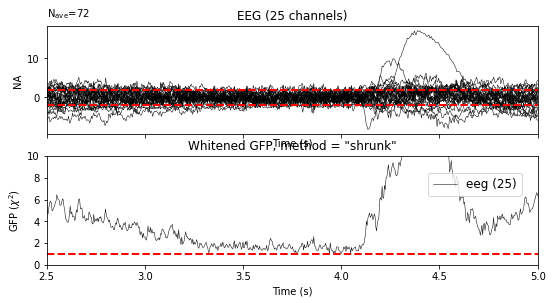

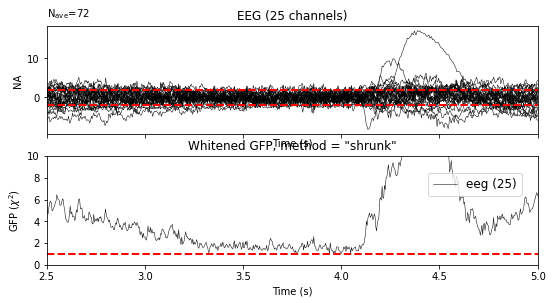

In [7]:
def custom_func(x):
    return x.max(axis=1)
for combine in ('mean', 'median', 'gfp', custom_func):
    mne.viz.plot_compare_evokeds([evoked_left,evoked_right], picks='eeg', combine=combine)
    
evoked_right.plot_white(noise_cov=noise_cov, time_unit='s')
evoked_left.plot_white(noise_cov=noise_cov, time_unit='s')
evoked_foot.plot_white(noise_cov=noise_cov, time_unit='s')
evoked_toungh.plot_white(noise_cov=noise_cov, time_unit='s')

### Применение независимого компонентного анализа (ICA)

Fitting ICA to data using 25 channels (please be patient, this may take a while)


C:\Users\pdlia\AppData\Local\Temp/ipykernel_8720/3871761617.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 18 components
Fitting ICA took 10.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 25 PCA components


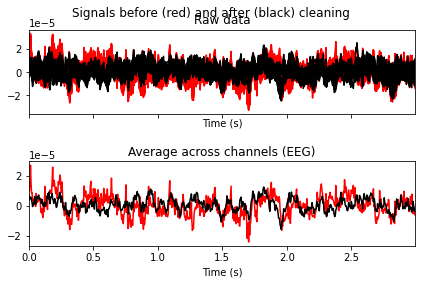

Creating RawArray with float64 data, n_channels=18, n_times=660530
    Range : 0 ... 660529 =      0.000 ...  2642.116 secs
Ready.


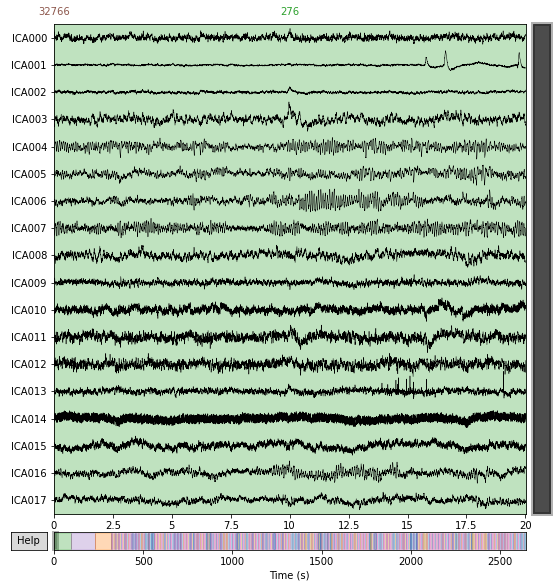

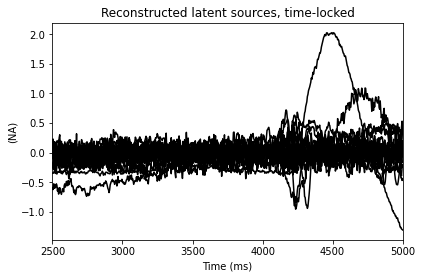

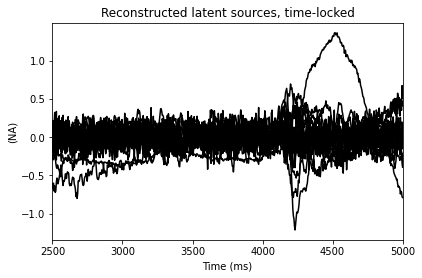

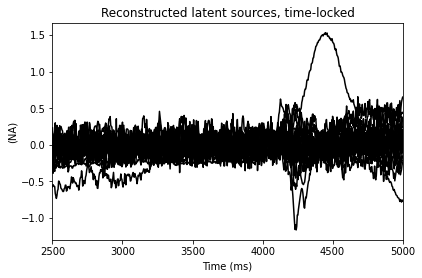

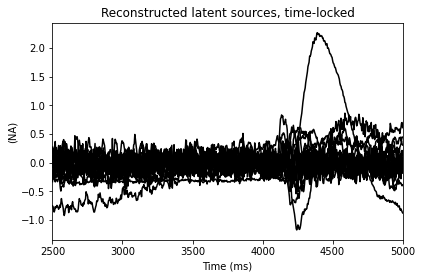

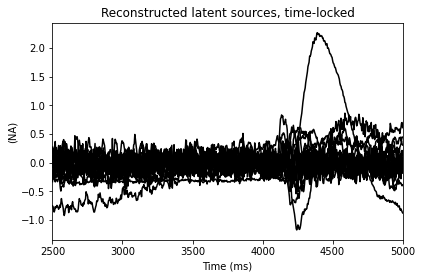

In [8]:
ica = mne.preprocessing.ICA(n_components=18,max_iter='auto',random_state=0) 
ica.fit(epochs)
ica.plot_overlay(raw, exclude=[0], picks='eeg')
ica.plot_sources(raw)
ica.plot_sources(evoked_left)
ica.plot_sources(evoked_right)
ica.plot_sources(evoked_foot)
ica.plot_sources(evoked_toungh)